# 🪐 Projeto NTTdata - Estrutura Medalhão


## Camada Bronze 🥉
 A camada Bronze consiste em **armazenar os arquivos brutos exatamente como recebidos**, sem qualquer tratamento, limpeza ou parsing.  
 
 O objetivo aqui é **preservar a integridade dos dados originais**, sem alterá-los.  

 No Databricks, utilizamos o método `text()` para armazenar os dados como linhas de texto puro, mantendo os acentos e caracteres como estão no arquivo de origem.

 A ingestão padrão foi feita via UX do Databricks criando o notebook.


### Exibindo que os CSVs foram importados com sucesso para dentro do ambiente

In [0]:
# Mostrar uma amostra das linhas brutas (cada linha como uma string)
print("Atendimentos - Bronze (dados brutos):")
df_atendimentos_bronze.show(5, truncate=False)

print("Cirurgias - Bronze (dados brutos):")
df_cirurgias_bronze.show(5, truncate=False)

print("Exames - Bronze (dados brutos):")
df_exames_bronze.show(5, truncate=False)

Atendimentos - Bronze (dados brutos):
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                       |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|atendimento_id,paciente_id,nome_paciente,doenca,localidade,especialidade,local_atendimento,data_atendimento,data_consulta,medico                                                            |
|60cd2245-b9c8-48cb-a48f-927efaad3509,8b34bd8e-e008-4e80-820f-9f55950a521b,Ana Julia Sousa,deserunt,Farias de Peixoto,repellendus,Alves Vasconcelos - EI,2021-06-02,2023-10-02,Francisco Lima|
|cc5603

# ⚙️ Silver Layer
Camada de transformação e limpeza dos dados brutos. Primeiras camadas de conversão / tratamentos da base que antes era "default"




- Aplicação de limpeza, padronização e estruturação.
- Remoção de duplicatas e inconsistências.
- Enriquecimento de dados com outras fontes para análises operacionais.


### Atendimentos (silver)

In [0]:
# ⚙️ Silver - leitura formatada dos CSVs
path_atendimentos = "dbfs:/FileStore/tables/atendimentos.csv"

# Leitura formatada
df_atendimentos = (
    spark.read
        .format("csv")
        .option("header", "true")
        .option("sep", ",")
        .option("encoding", "UTF-8")
        .load(path_atendimentos)
        # Tratamento de nulos específico para atendimentos
        .na.fill({
            'doenca': 'NÃO INFORMADA',
            'localidade': 'NÃO REGISTRADA',
            'especialidade': 'NÃO ESPECIFICADA',
            'local_atendimento': 'NÃO CADASTRADO',
            'medico': 'NÃO IDENTIFICADO'
        })
        # Conversão de datas para garantir formato correto
        .withColumn("data_atendimento", F.coalesce(F.to_date("data_atendimento", "yyyy-MM-dd"), F.lit(None)))
        .withColumn("data_consulta", F.coalesce(F.to_date("data_consulta", "yyyy-MM-dd"), F.lit(None)))
)

# Visualização já formatada
print("Atendimentos - Silver:")
display(df_atendimentos.limit(10))

# Salvar em Parquet
df_atendimentos.write.mode("overwrite").format("parquet").save("/mnt/silver/atendimentos")

Atendimentos - Silver:


atendimento_id,paciente_id,nome_paciente,doenca,localidade,especialidade,local_atendimento,data_atendimento,data_consulta,medico
60cd2245-b9c8-48cb-a48f-927efaad3509,8b34bd8e-e008-4e80-820f-9f55950a521b,Ana Julia Sousa,deserunt,Farias de Peixoto,repellendus,Alves Vasconcelos - EI,2021-06-02,2023-10-02,Francisco Lima
cc56033d-9d04-4aae-a00b-4062d983b1b0,5230cac3-ca7a-4664-a7eb-ddf8ac566ff9,Srta. Maria Flor Casa Grande,laudantium,Sá das Flores,quasi,Porto S/A,2022-09-30,2023-05-10,Dom Peixoto
e6b37369-6cff-4ae8-ac0c-e26bd9d64f09,a397f8be-faee-4367-a076-63128eaaaf11,Liam Moura,laborum,Pastor,ex,Costa - EI,2020-11-26,2022-06-28,Léo Fernandes
320f82d0-1832-456e-a3fa-93ed95d87821,c86209f6-ef67-4635-9c88-3ea84a4eae0b,Carolina Guerra,molestiae,Porto,inventore,da Costa,2022-06-18,2022-11-13,Stella Martins
70da2315-da79-4c45-9067-170f2d1d4e8f,0d972679-1452-420d-ac57-ab57cc28cf77,Benjamim Costela,laboriosam,da Costa Paulista,ullam,Machado - EI,2022-07-10,2024-01-14,Eduardo Oliveira
62a8fd77-85a6-4a18-994e-55ff9b8ddb11,dde3531c-5ed3-4509-bead-8f9fba487a02,Benjamin Nogueira,sequi,Ramos da Serra,a,Pinto,2020-12-28,2023-07-08,Carolina Azevedo
103c6bae-c036-490b-ba3a-c1e1105fe5c7,4a4eaced-332c-4730-bde9-22233dfe0277,Dr. Nathan Teixeira,optio,da Mota da Prata,ut,Correia,2023-06-11,2023-02-23,Valentina da Mata
a5ff6485-8173-42ff-b8fd-a39a27e12871,72b9a4c1-8946-4589-964c-ad4ccd7657cc,Sophie Gomes,laboriosam,Peixoto de Goiás,eligendi,da Cunha S.A.,2024-06-24,2022-07-15,Rodrigo Fonseca
94622a23-d9b8-4e46-80ba-3cbc6d0ad364,5d71c509-66c5-44b9-b75b-2f5e1d894edc,Bruna da Mata,voluptates,Martins,laudantium,Siqueira e Filhos,2024-04-07,2022-12-13,Luiz Gustavo Rios
3178c253-427e-44cb-823b-7d6c7b7137f0,b24de0ea-b39b-4ac5-a5b1-e0cfdd1146bb,Gael Henrique Almeida,animi,Mendonça,tenetur,Viana,2020-07-29,2021-08-16,Aylla Melo


### Cirurgias (silver)

In [0]:
# ⚙️ Silver - leitura formatada do CSV
path_cirurgias = "dbfs:/FileStore/tables/cirurgias_sus.csv"

# Leitura formatada
df_cirurgias = (
    spark.read
        .format("csv")
        .option("header", "true")
        .option("sep", ",")
        .option("encoding", "UTF-8")
        .load(path_cirurgias)
        # Tratamento de nulos específico para cirurgias
        .na.fill({
            'tipo_cirurgia': 'NÃO CATEGORIZADA',
            'doenca': 'NÃO DIAGNOSTICADA',
            'hospital': 'NÃO INFORMADO',
            'tipo_procedimento': 'NÃO ESPECIFICADO',
            'resultado_cirurgia': 'NÃO REGISTRADO'
        })
        # Garantir que o código do paciente seja string
        .withColumn("cod_paciente", F.coalesce(F.col("cod_paciente"), F.lit("SEM_CODIGO")))
        # Formatar data corretamente
        .withColumn("data_cirurgia", F.coalesce(F.to_date("data_cirurgia", "yyyy-MM-dd"), F.lit(None)))
)

# Visualização já formatada
print("Cirurgias - Silver:")
display(df_cirurgias.limit(10))

# Salvar em Parquet
df_cirurgias.write.mode("overwrite").format("parquet").save("/mnt/silver/cirurgias")

Cirurgias - Silver:


nome_paciente,data_cirurgia,cod_paciente,tipo_cirurgia,doenca,hospital,tipo_procedimento,nome_medico,resultado_cirurgia
Igor Lopes,2023-11-28,892256,Cirurgia torácica,Fratura óssea,Hospital São Paulo,Procedimento não invasivo,Rodrigo da Mota,Falha
João Miguel Ramos,2022-01-08,925794,Cirurgia ortopédica,Fratura óssea,Hospital Albert Einstein,Procedimento invasivo,Ana Lívia das Neves,Falha
Anna Liz Costa,2022-12-09,663278,Cirurgia plástica,Queimadura,Hospital Sírio-Libanês,Procedimento invasivo,Pedro da Mata,Complicações
Mirella Marques,2022-08-29,920507,Cirurgia plástica,Doença cardíaca,Hospital Albert Einstein,Procedimento invasivo,Sr. Pedro Henrique Fernandes,Sucesso
João Miguel da Mota,2023-08-03,494736,Cirurgia plástica,Doença pulmonar,Hospital Albert Einstein,Procedimento não invasivo,Benjamim Machado,Complicações
Sra. Raquel Azevedo,2024-10-23,640912,Cirurgia neurológica,Fratura óssea,Hospital Albert Einstein,Procedimento invasivo,Sr. Thales Dias,Falha
Maysa Nascimento,2024-03-08,866365,Cirurgia torácica,Queimadura,Hospital Sírio-Libanês,Procedimento não invasivo,Sra. Carolina Vargas,Complicações
Leandro Caldeira,2021-01-09,117949,Cirurgia neurológica,Doença pulmonar,Hospital das Clínicas,Procedimento não invasivo,Arthur Miguel Dias,Falha
João Pedro Novais,2022-05-25,367734,Cirurgia cardíaca,Doença pulmonar,Hospital São Paulo,Procedimento invasivo,Allana da Mota,Complicações
Fernando Novaes,2024-02-02,616787,Cirurgia plástica,Doença pulmonar,Hospital São Paulo,Procedimento não invasivo,Heloisa Costa,Falha


### Exames (silver)

In [0]:
# ⚙️ Silver - leitura formatada do CSV
path_exames = "dbfs:/FileStore/tables/exames.csv"

# Leitura formatada
df_exames = (
    spark.read
        .format("csv")
        .option("header", "true")
        .option("sep", ",")
        .option("encoding", "UTF-8")
        .load(path_exames)
        # Tratamento de nulos específico para exames
        .na.fill({
            'nome_exame': 'EXAME NÃO CATEGORIZADO',
            'solicitante': 'SOLICITANTE NÃO IDENTIFICADO',
            'localidade': 'LOCAL NÃO INFORMADO',
            'especialidade_solicitante': 'ESPECIALIDADE NÃO ESPECIFICADA'
        })
        # Garantir formato de data correto
        .withColumn("data_realizacao", F.coalesce(F.to_date("data_realizacao", "yyyy-MM-dd"), F.lit(None)))
        # Garantir que IDs não sejam nulos
        .withColumn("exame_id", F.coalesce(F.col("exame_id"), F.lit("ID_NAO_GERADO")))
        .withColumn("paciente_id", F.coalesce(F.col("paciente_id"), F.lit("PACIENTE_NAO_IDENTIFICADO")))
)

# Visualização já formatada
print("Exames - Silver :")
display(df_exames.limit(10))

# Salvar em Parquet
df_exames.write.mode("overwrite").format("parquet").save("/mnt/silver/exames")

Exames - Silver :


exame_id,paciente_id,nome_paciente,nome_exame,data_realizacao,solicitante,localidade,especialidade_solicitante
545c41de-d297-41b4-a429-84fd052cb8bb,dcc3dd51-60a2-47cf-8a56-4de21f6af200,Pedro Lucas Abreu,veniam,2024-03-21,Nicole Almeida,Guerra,necessitatibus
5e808b6d-df45-4d75-9ed7-ceb322127915,058fe562-c221-4210-821f-5a48b7ced8d4,Raquel Pacheco,dolor,2020-07-18,Isabelly Fernandes,Rios,suscipit
994e5797-88dc-485a-af62-bfe1407ba1c7,3f5756f9-d00c-4248-bd91-8c8b6edfa290,Dr. Caio Silveira,nam,2023-03-20,Ísis Montenegro,Jesus,odit
23384a8b-d852-4880-8487-9c4412cc2d6f,4d2bcb72-6251-4e08-9f06-ebac80402304,João Vitor Fernandes,voluptatem,2024-09-02,Bruno Guerra,Moraes,possimus
bb364ec8-de4a-4674-b98b-6c34e244e8b5,b8ef1a3c-20d2-4672-958f-9d64a7ff2c07,Luigi Nogueira,delectus,2022-09-06,Raquel Pacheco,Fonseca,sed
32c593bf-7919-4808-8a8d-b94333074b0c,b2350800-fd4f-49b8-b97b-bb0fbed80c64,Marina das Neves,dignissimos,2024-01-29,Sra. Isabella Peixoto,Cirino de Lopes,reprehenderit
4d817b7f-bb95-4ca1-a6eb-ca8d48187c29,361ad41d-d355-4e27-84d2-6d619e6bbeb1,João Felipe Viana,labore,2024-04-12,Júlia da Costa,Moura de Cunha,eveniet
3c66a4e4-9454-4421-bc7b-8470ddd9740a,b3763d53-2add-4ac0-af9d-70848e848df1,Hellena Cirino,explicabo,2025-04-23,Heitor Guerra,Macedo do Campo,voluptatem
b969a170-5785-44e1-845e-88427386abbe,1b69fadc-568e-49af-80ef-b36d4fb52d8c,Melina da Rosa,recusandae,2025-01-16,Sr. Yago Gonçalves,Vasconcelos Alegre,vel
419c519d-6439-4720-ac80-d1f32eabfc56,ef7b7fb2-1ce2-4f3c-8bc3-ba0508adb82b,Sr. Lorenzo Araújo,saepe,2022-06-20,Camila Cavalcanti,Pimenta,dolore


# 🟡 Camada Gold

### Introdução a Camada Gold

A Camada Gold é responsável por criar insights e visualizações a partir dos dados já preparados na camada Silver. Aqui, consolidamos informações e respondemos perguntas de negócio por meio de gráficos e tabelas.


-  Gerar visualizações gráficas para facilitar a interpretação dos dados.  
-  Apresentar métricas e indicadores relevantes baseado nos dados.  
-  Ajudar na tomada de decisões estratégicas, evidenciando tendências e padrões.  




### Importação das bibliotecas utilizadas para criação de gráficos

In [0]:
# Importações necessárias
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd

# Configuração de estilo
plt.style.use('ggplot')
sns.set_palette("husl")

## Tabela Cirurgias (gold)

### Análise dos Tipos de Cirurgia Mais Frequentes (Spark + Matplotlib)

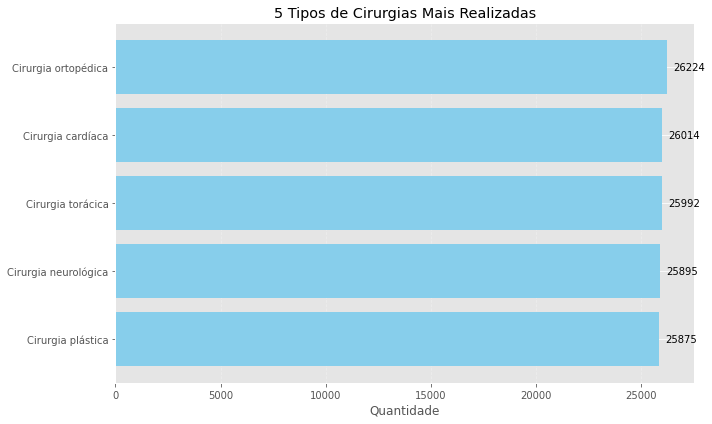

In [0]:
# 📥 Leitura do parquet
df_cirurgias_silver = spark.read.parquet("/mnt/silver/cirurgias")

# 📊 Agrupamento dos tipos de cirurgia
top_cirurgias = (
    df_cirurgias_silver.groupBy("tipo_cirurgia")
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
)

# 🔄 Conversão para pandas
top_cirurgias_pd = top_cirurgias.toPandas()

# 📈 Gráfico com melhorias visuais
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
bars = plt.barh(top_cirurgias_pd["tipo_cirurgia"], top_cirurgias_pd["count"], color='skyblue')
plt.xlabel("Quantidade")
plt.title("5 Tipos de Cirurgias Mais Realizadas")
plt.gca().invert_yaxis()

# 🧾 Adiciona rótulos de valor ao lado das barras
for bar in bars:
    width = bar.get_width()
    plt.text(width + 300, bar.get_y() + bar.get_height()/2, f'{int(width)}', va='center')

plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()


### Análise de Resultados Cirúrgicos (Matplotlib)

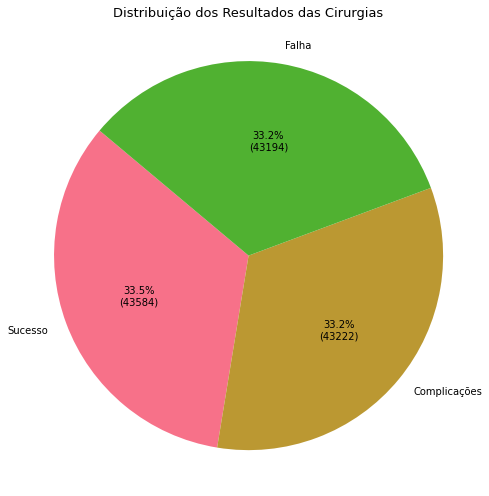

In [0]:
resultados = (
    df_cirurgias_silver.groupBy("resultado_cirurgia")
    .count()
    .orderBy("count", ascending=False)
)

resultados_pd = resultados.toPandas()

# Função para exibir % + valor
def format_label(pct, allvals):
    total = sum(allvals)
    val = int(round(pct * total / 100.0))
    return f'{pct:.1f}%\n({val})'

plt.figure(figsize=(7,7))
wedges, texts, autotexts = plt.pie(
    resultados_pd["count"],
    labels=resultados_pd["resultado_cirurgia"],
    autopct=lambda pct: format_label(pct, resultados_pd["count"]),
    startangle=140,
    textprops=dict(color="black", fontsize=10)
)

plt.title("Distribuição dos Resultados das Cirurgias", fontsize=13)
plt.axis("equal")
plt.tight_layout()
plt.show()


## Tabelas Exames (gold)

### Distribuição dos 10 Exames Mais Realizados (Matplotlib)

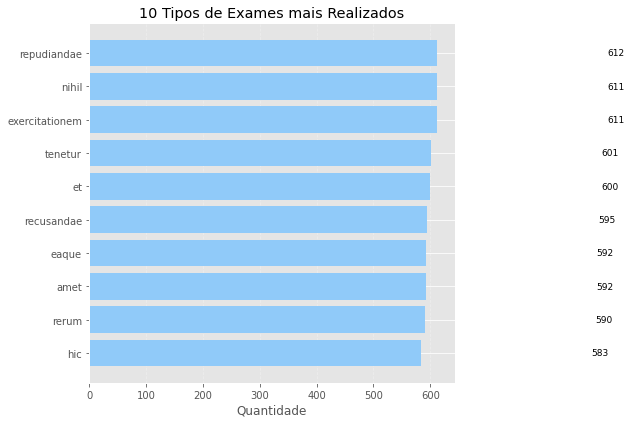

In [0]:
# 📥 Leitura da camada Silver dos exames
df_exames_silver = spark.read.parquet("/mnt/silver/exames")

# 📊 Agrupamento dos exames por nome
exames_agg = (
    df_exames_silver.groupBy("nome_exame")
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
)

# 🔄 Conversão para Pandas
exames_pd = exames_agg.toPandas()

# 📈 Gráfico com valores absolutos
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
bars = plt.barh(exames_pd["nome_exame"], exames_pd["count"], color='#90caf9')
plt.xlabel("Quantidade")
plt.title("10 Tipos de Exames mais Realizados")
plt.gca().invert_yaxis()

# 🧾 Adiciona os valores ao lado das barras
for bar in bars:
    width = bar.get_width()
    plt.text(width + 300, bar.get_y() + bar.get_height()/2, f'{int(width)}', va='center', fontsize=9)

plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### Distribuição das Doenças que Mais Levaram a Cirurgias (Matplotlib)

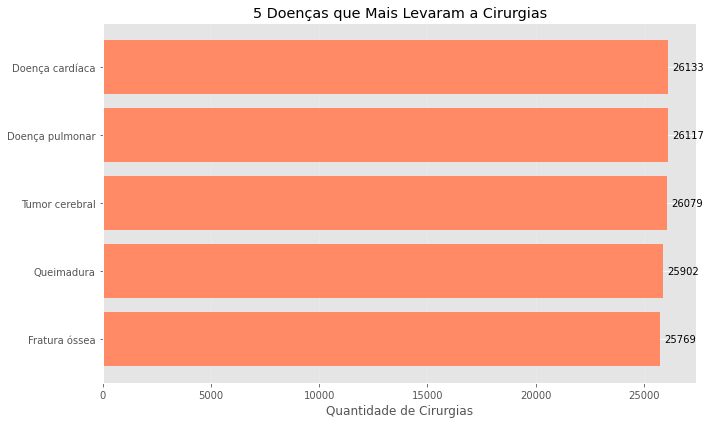

In [0]:
top_doencas = (
    df_cirurgias_silver.groupBy("doenca")
    .count()
    .orderBy("count", ascending=False)
    .limit(5)
)

top_doencas_pd = top_doencas.toPandas()

plt.figure(figsize=(10,6))
bars = plt.barh(top_doencas_pd["doenca"], top_doencas_pd["count"], color="#ff8a65")
plt.title("5 Doenças que Mais Levaram a Cirurgias")
plt.xlabel("Quantidade de Cirurgias")
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 200, bar.get_y() + bar.get_height()/2, f'{int(width)}', va='center')

plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()


## Tabela Atendimentos (gold)

### Distribuição de Atendimentos por Localidade (Matplotlib)

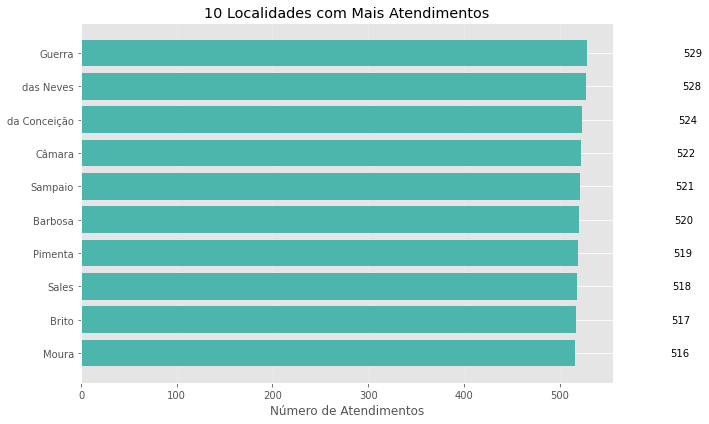

In [0]:
df_atendimentos_silver = spark.read.parquet("/mnt/silver/atendimentos")

top_localidades = (
    df_atendimentos_silver.groupBy("localidade")
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
)

top_localidades_pd = top_localidades.toPandas()

plt.figure(figsize=(10,6))
bars = plt.barh(top_localidades_pd["localidade"], top_localidades_pd["count"], color="#4db6ac")
plt.title("10 Localidades com Mais Atendimentos")
plt.xlabel("Número de Atendimentos")
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 100, bar.get_y() + bar.get_height()/2, f'{int(width)}', va='center')

plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()


### Frequência de Atendimentos por Especialidade Médica (Matplotlib)


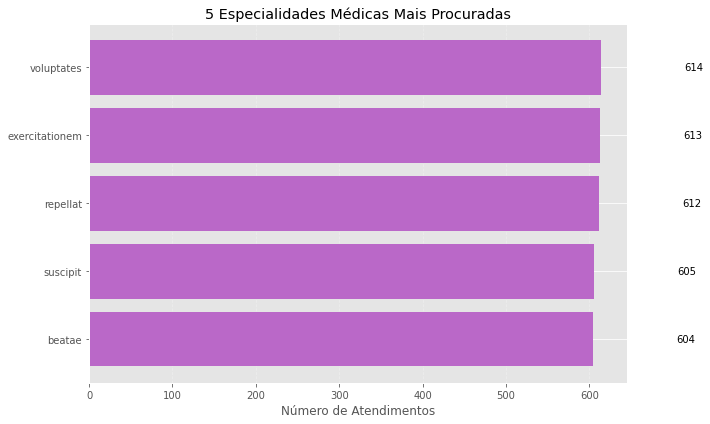

In [0]:
top_especialidades = (
    df_atendimentos_silver.groupBy("especialidade")
    .count()
    .orderBy("count", ascending=False)
    .limit(5)
)

top_especialidades_pd = top_especialidades.toPandas()

plt.figure(figsize=(10,6))
bars = plt.barh(top_especialidades_pd["especialidade"], top_especialidades_pd["count"], color="#ba68c8")
plt.title("5 Especialidades Médicas Mais Procuradas")
plt.xlabel("Número de Atendimentos")
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 100, bar.get_y() + bar.get_height()/2, f'{int(width)}', va='center')

plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()


##  Visualizações Gold com Joins Estratégicos

### Perfomance Hospitalar quantidade de cirurgias x sucesso nas cirurgias (plotly)

**Tabelas:**

**df_cirurgias (única tabela)**

Campos: hospital, resultado_cirurgia, nome_medico

**Métricas calculadas:**

Contagem total de cirurgias por hospital

Taxa de sucesso (resultado_cirurgia == "Sucesso")

Número de médicos distintos

In [0]:
# JOIN e cálculo de métricas
df_hospitais = (
    df_cirurgias.groupBy("hospital")
    .agg(
        F.count("*").alias("total_cirurgias"),
        (F.avg(F.when(F.col("resultado_cirurgia") == "Sucesso", 1).otherwise(0)) * 100).alias("taxa_sucesso"), 
        F.countDistinct("nome_medico").alias("qtd_medicos")
    )
    .orderBy(F.col("taxa_sucesso").desc())
    .limit(8)
    .toPandas()
)


# Visualização interativa
fig = px.scatter(
    df_hospitais,
    x="total_cirurgias",
    y="taxa_sucesso",
    size="qtd_medicos",
    color="hospital",
    hover_name="hospital",
    title="Performance Hospitalar: Volume vs Sucesso Cirúrgico",
    labels={
        "total_cirurgias": "Total de Cirurgias",
        "taxa_sucesso": "Taxa de Sucesso (%)",
        "qtd_medicos": "Número de Médicos"
    }
)

fig.update_layout(
    yaxis_title="Taxa de Sucesso (%)" 
)
fig.update_layout(height=600)
fig.show()

### Relação Pacientes x Cirurgias por Doença (MatplotLib)

### Evolução Temporal Atendimentos vs Cirurgias (Matplotlib)

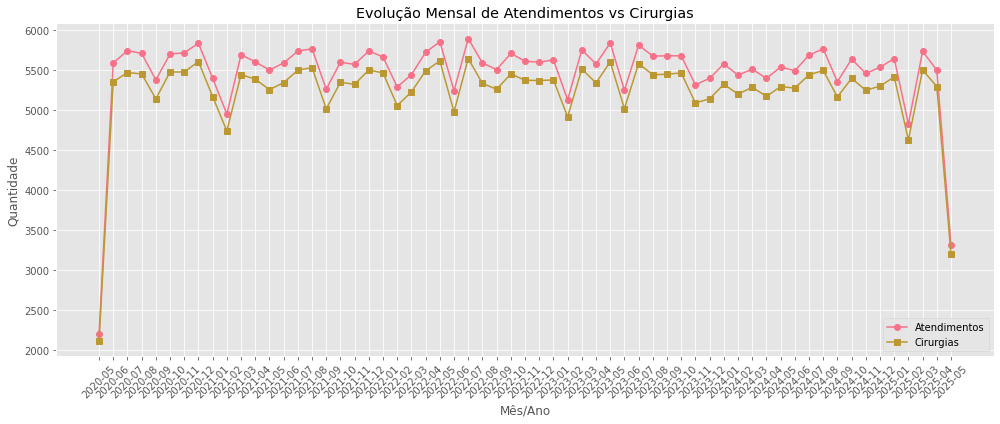

In [0]:
# JOIN e preparação temporal
df_evolucao = (
    df_atendimentos.withColumn("mes_atendimento", F.date_format("data_atendimento", "yyyy-MM"))
    .join(
        df_cirurgias.withColumn("mes_cirurgia", F.date_format("data_cirurgia", "yyyy-MM")),
        df_atendimentos["nome_paciente"] == df_cirurgias["nome_paciente"],
        "left"
    )
    .groupBy("mes_atendimento")
    .agg(
        F.count(df_atendimentos["atendimento_id"]).alias("atendimentos"),
        F.count(df_cirurgias["tipo_cirurgia"]).alias("cirurgias")
    )
    .orderBy("mes_atendimento")
    .toPandas()
)

# Visualização
plt.figure(figsize=(14, 6))
plt.plot(df_evolucao['mes_atendimento'], df_evolucao['atendimentos'], marker='o', label='Atendimentos')
plt.plot(df_evolucao['mes_atendimento'], df_evolucao['cirurgias'], marker='s', label='Cirurgias')

plt.title('Evolução Mensal de Atendimentos vs Cirurgias')
plt.xlabel('Mês/Ano')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()